In [1]:
from collections import Counter
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 載入資料集

In [2]:
x, y = load_breast_cancer(return_X_y=True, as_frame=True)

In [3]:
x.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

# 顯示資料分佈

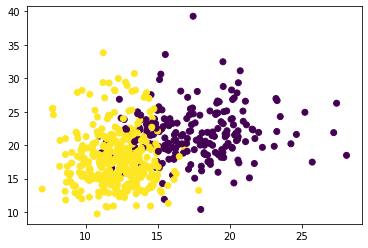

In [5]:
plt.scatter(x['mean radius'], x['mean texture'], c=y) # 特徵共有30維 僅用前2維作圖

# 拆分訓練集與測試集

In [6]:
train_x, test_x, train_y, test_y = train_test_split(x, y)
print(train_x.shape)
print(train_y.shape)

(426, 30)
(426,)


# 引用決策樹實現

In [7]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.label = label
        self.left = left
        self.right = right

    @property
    def is_leaf(self):
        return self.label is not None

In [8]:
class DecisionTree:
    def __init__(self, max_depth, min_samples_split):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def fit(self, x, y):
        self.root = self._grow_tree(x, y)
    
    def predict(self, x):
        # 一次以單個樣本遍歷決策樹
        # 葉子的標籤即為預測值
        return [ self._traverse_tree(self.root, sample) for _, sample in x.iterrows() ]
    
    def _grow_tree(self, x, y, depth=0):
        n_samples = x.shape[0]
        n_labels = len(np.unique(y))
        if (depth > self.max_depth
            or n_samples < self.min_samples_split 
            or n_labels == 1):
            label = self._most_common_label(y)
            return Node(label=label)
        
        # 根據最佳策略分裂左右子樹
        best_feature, best_threshold = self._find_criteria(x, y)
        left_x, left_y, right_x, right_y = self._split_dataset(x, y, best_feature, best_threshold)
        left = self._grow_tree(left_x, left_y, depth+1)
        right = self._grow_tree(right_x, right_y, depth+1)
        return Node(best_feature, best_threshold, left, right)
    
    def _most_common_label(self, y):
        """返回標籤中的眾數"""
        counter = Counter(y)
        return counter.most_common(1)[0][0]
    
    def _find_criteria(self, x, y):
        """
        根據信息增益尋找分裂點
        返回一組特徵與閾值
        增益越大代表提供較多信息量
        即此分裂策略能消除較多不確定性
        """
        # 遍歷每個特徵的每個閾值
        # 計算各種組合的信息增益
        # 取能提供最多增益的組合
        # 四捨五入減少閾值量加速訓練
        return max([
            (feature, threshold)
            for feature in x
            for threshold in np.unique(x[feature].round(3))
        ], key=lambda pair: self._information_gain(x, y, pair[0], pair[1]))
    
    def _information_gain(self, x, y, feature, threshold):
        _, left_y, _, right_y = self._split_dataset(x, y, feature, threshold)
        # 若無法拆分左右子樹相當於無分類效果
        if len(left_y) == 0 or len(right_y) == 0:
            return 0
        
        parent_entropy = self._entropy(y)
        n = len(y)
        child_entropy = (len(left_y) / n * self._entropy(left_y) 
                         + len(right_y) / n * self._entropy(right_y))
        return parent_entropy - child_entropy
    
    def _split_dataset(self, x, y, feature, threshold):
        """根據特徵與閾值拆分資料集"""
        left_mask = x[feature] < threshold
        right_mask = ~left_mask
        return x[left_mask], y[left_mask], x[right_mask], y[right_mask]
        
    def _entropy(self, y):
        p = y.value_counts() / len(y)
        return -sum(p * np.log2(p))
    
    def _traverse_tree(self, node, sample):
        if node.is_leaf:
            return node.label
        
        if sample[node.feature] < node.threshold:
            return self._traverse_tree(node.left, sample)
        else:
            return self._traverse_tree(node.right, sample)

# 主要算法實現

In [9]:
class RandomForest:
    def __init__(self, n_trees, max_depth, min_samples_split):
        self.trees = [ DecisionTree(max_depth, min_samples_split) for _ in range(n_trees) ]
    
    def fit(self, x, y):
        for tree in self.trees:
            tree.fit(*self._bootstrapping(x, y))
    
    def predict(self, x):
        preds = [ tree.predict(x) for tree in self.trees ]
        return list(map(self._most_common_label, np.swapaxes(preds, 0, 1)))
    
    def _bootstrapping(self, x, y):
        n_samples = x.shape[0]
        idxs = np.random.choice(n_samples, n_samples)
        return x.iloc[idxs], y.iloc[idxs]
    
    def _most_common_label(self, y):
        """返回標籤中的眾數"""
        counter = Counter(y)
        return counter.most_common(1)[0][0]

In [10]:
rf = RandomForest(n_trees=3, max_depth=5, min_samples_split=5)
rf.fit(train_x, train_y)

# 驗證算法準確率

In [11]:
preds = rf.predict(test_x)
print("Accuracy:", (preds == test_y).mean())

Accuracy: 0.9440559440559441


# 可視化驗證

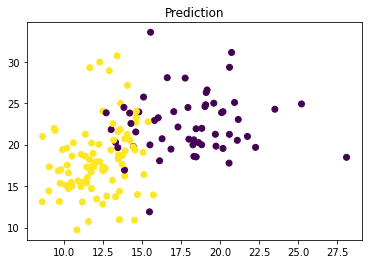

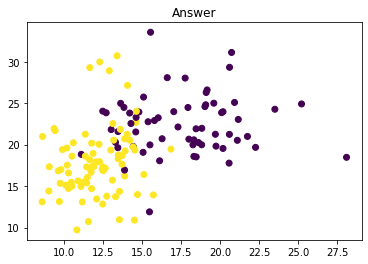

In [12]:
plt.title("Prediction")
plt.scatter(test_x['mean radius'], test_x['mean texture'], c=preds)
plt.show()

plt.title("Answer")
plt.scatter(test_x['mean radius'], test_x['mean texture'], c=test_y)
plt.show()